In [33]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras_contrib.layers.normalization.instancenormalization import InstanceNormalization

hello there


In [34]:
def transform_resnet_block(nrOfFilters, inputLayer):
    init = keras.initializers.RandomNormal(stddev=0.02)
    resnet = keras.layers.Conv2D(nrOfFilters, (3,3), padding='same', kernel_initializer=init)(inputLayer)
    # instead of Batchnormalization
    resnet = InstanceNormalization(axis=-1)(resnet)
    resnet = keras.layers.Activation('relu')(resnet)
    # TODO reflection padding
    resnet = keras.layers.Conv2D(nrOfFilters, (3,3), padding='same', kernel_initializer=init)(resnet)
    resnet = InstanceNormalization(axis=-1)(resnet)
    resnet = keras.layers.Concatenate()([resnet, inputLayer])
    return resnet



In [35]:
# TODO generator model to use 6 ResNet layers as is used in the cycleGAN paper
def general_generator(imageShape=(256,256,3), nrOfResnet=9):
    init = keras.initializers.RandomNormal(stddev=0.02)
    inputImage = keras.Input(shape=imageShape)
    # ----Encode ------
    generator = keras.layers.Conv2D(64, (7,7), padding='same', kernel_initializer=init)(inputImage)
    generator = InstanceNormalization(axis=-1)(generator)
    generator = keras.layers.Activation('relu')(generator)

    generator = keras.layers.Conv2D(128, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(generator)
    generator = InstanceNormalization(axis=-1)(generator)
    generator = keras.layers.Activation('relu')(generator)

    generator = keras.layers.Conv2D(256, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(generator)
    generator = InstanceNormalization(axis=-1)(generator)
    generator = keras.layers.Activation('relu')(generator)

    # ----Transform -----
    for _ in range(nrOfResnet):
        generator = transform_resnet_block(256, generator)
    # ----Decode ------
    generator = keras.layers.Conv2DTranspose(128, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(generator)
    generator = InstanceNormalization(axis=-1)(generator)
    generator = keras.layers.Activation('relu')(generator)

    generator = keras.layers.Conv2DTranspose(64, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(generator)
    generator = InstanceNormalization(axis=-1)(generator)
    generator = keras.layers.Activation('relu')(generator)

    generator = keras.layers.Conv2D(3, (7,7), padding='same', kernel_initializer=init)(generator)
    generator = InstanceNormalization(axis=-1)(generator)
    outputImage = keras.layers.Activation('tanh')(generator)

    model = keras.Model(inputImage, outputImage)
    return model



In [36]:
model = general_generator()
model.summary()

Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d_105 (Conv2D)             (None, 256, 256, 64) 9472        input_8[0][0]                    
__________________________________________________________________________________________________
instance_normalization_107 (Ins (None, 256, 256, 64) 128         conv2d_105[0][0]                 
__________________________________________________________________________________________________
activation_59 (Activation)      (None, 256, 256, 64) 0           instance_normalization_107[0][0] 
____________________________________________________________________________________________

In [37]:
from keras.optimizers import Adam
from keras.initializers import RandomNormal
from keras.models import Model
from keras.models import Input
from keras.layers import Conv2D
from keras.layers import LeakyReLU
from keras.layers import Activation
from keras.layers import Concatenate
from keras.layers import BatchNormalization
from keras_contrib.layers.normalization.instancenormalization import InstanceNormalization

def general_discriminator(imageShape):
    init = RandomNormal(stddev=0.02)
    inputImage = Input(shape=imageShape)

    discriminator = Conv2D(64, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(inputImage)
    discriminator = LeakyReLU(alpha=0.2)(discriminator)

    discriminator = Conv2D(128, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(discriminator)
    discriminator = InstanceNormalization(axis=-1)(discriminator)
    discriminator = LeakyReLU(alpha=0.2)(discriminator)

    discriminator = Conv2D(256, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(discriminator)
    discriminator = InstanceNormalization(axis=-1)(discriminator)
    discriminator = LeakyReLU(alpha=0.2)(discriminator)

    discriminator = Conv2D(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(discriminator)
    discriminator = InstanceNormalization(axis=-1)(discriminator)
    discriminator = LeakyReLU(alpha=0.2)(discriminator)

    discriminator = Conv2D(512, (4,4), padding='same', kernel_initializer=init)(discriminator)
    discriminator = InstanceNormalization(axis=-1)(discriminator)
    discriminator = LeakyReLU(alpha=0.2)(discriminator)

    output = Conv2D(1, (4,4), padding='same', kernel_initializer=init)(discriminator)
    model = Model(inputImage, output)
    # TODO negative log likelihood (e.g. binary cross entropy).
    model.compile(loss='mse', optimizer=Adam(learning_rate=0.0002, beta_1=0.5), loss_weights=[0.5])
    return model


In [38]:
imageShape = (256,256, 3)
model = general_discriminator(imageShape)
model.summary()

Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
conv2d_127 (Conv2D)          (None, 128, 128, 64)      3136      
_________________________________________________________________
leaky_re_lu_15 (LeakyReLU)   (None, 128, 128, 64)      0         
_________________________________________________________________
conv2d_128 (Conv2D)          (None, 64, 64, 128)       131200    
_________________________________________________________________
instance_normalization_131 ( (None, 64, 64, 128)       256       
_________________________________________________________________
leaky_re_lu_16 (LeakyReLU)   (None, 64, 64, 128)       0         
_________________________________________________________________
conv2d_129 (Conv2D)          (None, 32, 32, 256)       5245

In [41]:
# Mean squared error, lambda 1
def adversarial_loss_model(generator, discriminator, imageShape):
    inputGenerator = Input(shape=imageShape)
    generatorOutput = generator(inputGenerator)
    outputDiscriminator = discriminator(generatorOutput)
    model = Model(inputGenerator, outputDiscriminator)
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='mse', loss_weights=[1], optimizer=opt)
    return model

# If something already looks like from the target domain, you should not map it into a different image.
#Identity loss says that, if you fed image Y to generator G, it should yield the real image Y or something close to image Y.
# Mean absolute error, lambda 5
def identity_loss_model(generator, imageShape):
    inputIdentity = Input(shape=imageShape)
    outputIdentity = generator(inputIdentity)
    model = Model(inputIdentity, outputIdentity)
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='mae', loss_weights=[5], optimizer=opt)
    return model

# Mean absolute error, lambda 10
def forward_cycle_loss_model(generatorG, generatorF, imageShape):
    inputGenerator = Input(shape=imageShape)
    generatorG_output = generatorG(inputGenerator)
    generatorF_output = generatorF(generatorG_output)
    model = Model(inputGenerator, generatorF_output)
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='mae', loss_weights=[10], optimizer=opt)
    return model

# Mean absolute error, lambda 10
def backward_cycle_loss_model(generatorG, generatorF, imageShape):
    inputGenerator = Input(shape=imageShape)
    generatorF_output = generatorF(inputGenerator)
    generatorG_output = generatorG(generatorF_output)
    model = Model(inputGenerator, generatorG_output)
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='mae', loss_weights=[10], optimizer=opt)
    return model


In [44]:
# test code ---
imageShape = (256,256, 3)
# generator G(x) -> y'
Gx_2_y = general_generator(imageShape)
# generator F(y') -> x'
Fy_2_x = general_generator(imageShape)
# discriminator D(y') -> real/fake painting?
Dy = general_discriminator(imageShape)
# discriminator D(x') -> real/fake landscape?
Dx = general_discriminator(imageShape)

adversarial_loss_model_G = adversarial_loss_model(Gx_2_y, Dy, imageShape)
identity_loss_model_G = identity_loss_model(Gx_2_y, imageShape)
forward_cycle_loss_model_G = forward_cycle_loss_model(Gx_2_y, Fy_2_x, imageShape)
backward_cycle_loss_model_G = backward_cycle_loss_model(Gx_2_y, Fy_2_x, imageShape)

adversarial_loss_model_F = adversarial_loss_model(Fy_2_x, Dx, imageShape)
identity_loss_model_F = identity_loss_model(Fy_2_x, imageShape)
forward_cycle_loss_model_F = forward_cycle_loss_model(Fy_2_x, Gx_2_y, imageShape)
backward_cycle_loss_model_F = backward_cycle_loss_model(Fy_2_x, Gx_2_y, imageShape)

print("disc a shape: ", Dy.output_shape)

disc a shape:  (None, 16, 16, 1)


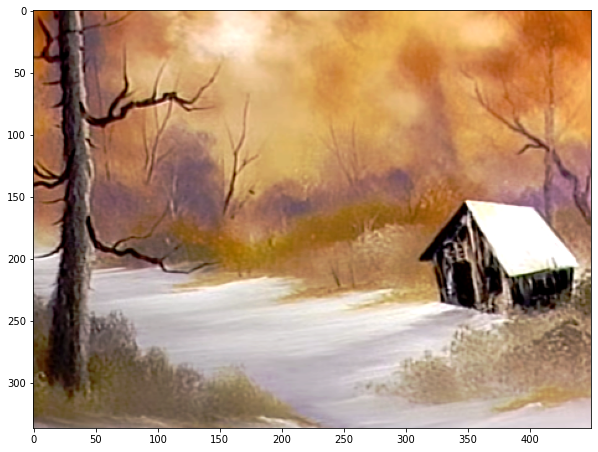

In [53]:
from matplotlib import pyplot as plt
test_image = cv.imread('./data/bobross_paintings/painting5.png')
test_image_bgr = cv.cvtColor(test_image, cv.COLOR_RGB2BGR)
figure = plt.figure(figsize=(10,10))
plt.imshow(test_image_bgr)
plt.show()

In [64]:
tfds_cache_dir = os.path.join(os.getcwd(),'tfds_cache')
os.makedirs(tfds_cache_dir, exist_ok = True)

# Note: The Keras home directory is hard-coded to
# "~/.keras" (Linux) or "%USERPROFILE%\.keras" on Windows
# so any model weights downloaded from "keras.applications"
# will be found there (in the sub-directory "models").
home_dir = os.path.expanduser("~")
keras_dir = os.path.join(home_dir,'.keras')
if os.path.isdir(keras_dir):
    print(os.listdir(keras_dir))

os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
if tf.test.gpu_device_name():
    print('GPU found')
else:
    print('No GPU found')

batch_size = 16
img_height = 256
img_width = 256
data_dir_bob = './data/bobross_paintings'

train_ds_bob = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_bob,
  validation_split=0.025,
  subset="training",
  seed=1337,
  image_size=(img_height, img_width),
  batch_size=batch_size
)

val_ds_bob = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_bob,
  validation_split=0.025,
  subset="validation",
  seed=1337,
  image_size=(img_height, img_width),
  batch_size=batch_size
)


['keras.json', 'models']
No GPU found
Found 403 files belonging to 1 classes.
Using 393 files for training.
Found 403 files belonging to 1 classes.
Using 10 files for validation.


In [71]:
batch_size = 16
img_height = 256
img_width = 256
data_dir_landscapes = './data/landscape_pictures'

train_ds_landscapes = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_landscapes,
  validation_split=0.025,
  subset="training",
  seed=1337,
  image_size=(img_height, img_width),
  batch_size=batch_size
)

val_ds_landscapes = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_landscapes,
  validation_split=0.025,
  subset="validation",
  seed=1337,
  image_size=(img_height, img_width),
  batch_size=batch_size
)

image_batch, labels_batch = next(iter(train_ds_landscapes))
first_image = image_batch[0]
print(len(image_batch))
print(first_image)

Found 4319 files belonging to 1 classes.
Using 4212 files for training.
Found 4319 files belonging to 1 classes.
Using 107 files for validation.
16
256
tf.Tensor(
[[[132.82202  154.82202  168.82202 ]
  [125.03003  146.61401  167.61401 ]
  [124.166016 144.927    170.82397 ]
  ...
  [ 88.573    129.823    161.823   ]
  [ 89.       130.       162.      ]
  [ 89.       130.       162.      ]]

 [[127.65112  148.65112  167.15503 ]
  [114.21118  139.5581   162.83813 ]
  [111.618164 138.37012  165.37012 ]
  ...
  [ 88.843994 130.094    162.094   ]
  [ 89.       130.       162.      ]
  [ 89.       130.       162.      ]]

 [[120.50513  142.50513  166.02002 ]
  [108.51001  139.28491  166.90479 ]
  [ 88.16553  124.69531  151.89038 ]
  ...
  [ 89.75     131.       163.      ]
  [ 90.       131.       163.      ]
  [ 90.       131.       163.      ]]

 ...

 [[135.69531  141.60522  129.79541 ]
  [138.18018  141.3103   134.42041 ]
  [138.58496  144.70996  133.3501  ]
  ...
  [ 82.289795  93.664795

In [ ]:
def generate_batch_of_samples(trainset, batchSize, shape):
    AUTOTUNE = tf.data.AUTOTUNE
    train_ds_bob = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
    image_batch, labels_batch = next(iter(train_ds_bob))

In [ ]:
def train(Gx2y, Fy2x, Dy, Dx, advLossModel, idLossModel, forwardLossModel, backwardLossModel, trainBob, trainLandscape):
    # -----test -------------
    imageShape = (256,256, 3)
    # generator G(x) -> y'
    Gx2y = general_generator(imageShape)
    # generator F(y') -> x'
    Fy2x = general_generator(imageShape)
    # discriminator D(y') -> real/fake painting?
    Dy = general_discriminator(imageShape)
    # discriminator D(x') -> real/fake landscape?
    Dx = general_discriminator(imageShape)
    # losses
    adversarial_loss_model_G = advLossModel(Gx2y, Dy, imageShape)
    identity_loss_model_G = idLossModel(Gx2y, imageShape)
    forward_cycle_loss_model_G = forwardLossModel(Gx2y, Fy2x, imageShape)
    backward_cycle_loss_model_G = backwardLossModel(Gx2y, Fy2x, imageShape)

    adversarial_loss_model_F = advLossModel(Fy2x, Dx, imageShape)
    identity_loss_model_F = idLossModel(Fy2x, imageShape)
    forward_cycle_loss_model_F = forwardLossModel(Fy2x, Gx2y, imageShape)
    backward_cycle_loss_model_F = backwardLossModel(Fy2x, Gx2y, imageShape)
    # -----end test -------
    
    
    
    epochs, batchSize = 10, 16
    trainX, trainY = trainLandscape, trainBob
    poolG, poolF = list(), list()
    # calculate the number of batches per training epoch
	batchPerEpoch= int(len(trainX) / batchSize)
	# calculate the number of training iterations
    # TODO what if size trainX >> trainY??
	steps = batchPerEpoch * epochs

    for i in range(steps):
        yPrime = Gx2y.predict()
